In [1]:
# importing necessary librarise

import numpy as np
import gym
import matplotlib.pyplot as plt
# import the user made deep q-learning class
from DeepQLearning import DQN

In [2]:
# Training Deep q-learning network

def train_dqn(episode):

    loss = []
    
    # getting the agent from DQN class (environment)
    agent = DQN(env.action_space.n, env.observation_space.shape[0])
    
    #iterate for each episode
    for e in range(episode):
        
        # getting a state by reseting the environment
        state = env.reset()
        state = np.reshape(state, (1, 4))
        score = 0
        max_steps = 3000
        
        #for all states in each episode
        for i in range(max_steps):
            # getting the action from environment at a particular state
            action = agent.act(state)
            env.render()
            
            # calculating the reward and next state for a selected action
            next_state, reward, done, _ = env.step(action)
            score += reward
            next_state = np.reshape(next_state, (1, 4))
            
            # adding the agents learning to memory
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        loss.append(score)

        # Average score of last 100 episode
        is_solved = np.mean(loss[-100:])
        if is_solved > 50:
            print('\n Task Completed! \n')
            agent.save_model()
            break
        print("Average over last 100 episode: {0:.2f} \n".format(is_solved))
    return loss

In [3]:
# Creating an environment of Cartpole-v0

env = gym.make('CartPole-v0')
env.seed(0)
np.random.seed(0)

Box(4,)
Discrete(2)
episode: 0/400, score: 14.0
Average over last 100 episode: 14.00 

episode: 1/400, score: 12.0
Average over last 100 episode: 13.00 

episode: 2/400, score: 12.0
Average over last 100 episode: 12.67 

episode: 3/400, score: 8.0
Average over last 100 episode: 11.50 

episode: 4/400, score: 19.0
Average over last 100 episode: 13.00 

episode: 5/400, score: 11.0
Average over last 100 episode: 12.67 

episode: 6/400, score: 39.0
Average over last 100 episode: 16.43 

episode: 7/400, score: 17.0
Average over last 100 episode: 16.50 

episode: 8/400, score: 19.0
Average over last 100 episode: 16.78 

episode: 9/400, score: 14.0
Average over last 100 episode: 16.50 

episode: 10/400, score: 9.0
Average over last 100 episode: 15.82 

episode: 11/400, score: 12.0
Average over last 100 episode: 15.50 

episode: 12/400, score: 17.0
Average over last 100 episode: 15.62 

episode: 13/400, score: 11.0
Average over last 100 episode: 15.29 

episode: 14/400, score: 13.0
Average ove

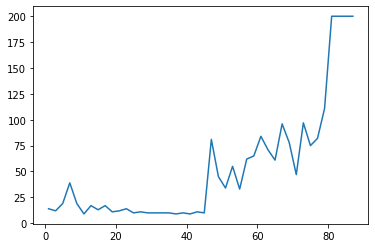

In [4]:
# print the output and plot the graph 

print(env.observation_space)
print(env.action_space)
episodes = 400
loss = train_dqn(episodes)
plt.plot([i+1 for i in range(0, len(loss), 2)], loss[::2])
plt.show()